In [1]:
import logging
from Generator import Generator
from VertexProperty import VertexProperty
import sys
import graph_tool.all as gt
from Rule import Rule, RHS, LHS
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from bson import json_util
from bson.objectid import ObjectId
import argparse
from os import path
import json
import uuid
import networkx as nx
import shutil
from Metrics import MapLinearity, MissionLinearity,Leniency, PathRedundancy
import matplotlib.pyplot as plt
from os.path import isfile, join, isdir
from os import listdir, mkdir, remove
import pickle
import pandas as pd

In [2]:
def makeGraph(mongoGraph):
    g = gt.Graph()
    IDtoIndex = {}
    vertices = []
    g.vertex_properties["vertex_property"] = g.new_vertex_property("python::object")
    for i, node in enumerate(mongoGraph["nodes"]):
        v = g.add_vertex()
        IDtoIndex[node["id"]] = i
        abbrev = node["abbrev"]
        label = node["label"]
        terminality = False
        mark = node["mark"]

        vertices.append(v)
        g.vp.vertex_property[v] = VertexProperty(label, abbrev, terminality, mark)

    for edge in mongoGraph["edges"]:
        u = vertices[IDtoIndex[edge["from"]]]
        v = vertices[IDtoIndex[edge["to"]]]
        g.add_edge(u, v)
    return g


def makeGrammar(grammar):
    axiom = makeGraph(grammar["axiom"])
    # gt.graph_draw(axiom, vertex_text=abbrevs, output="img/axiom.png")

    rules = []
    for i, rule in enumerate(grammar["rules"]):
        rule_name = rule["name"]
        rule_lhs = rule["lhs"]
        lhs_graph = makeGraph(rule_lhs)
        lhs = LHS(lhs_graph)
        # gt.graph_draw(lhs_graph, vertex_text=lhs_abbrevs, output="lhs"+ str(i) +".png")
        rule_rhss = rule["rhs"]
        rhss = []
        for j, rule_rhs in enumerate(rule_rhss):
            rhs_graph = makeGraph(rule_rhs["graph"])
            rhs = RHS(rhs_graph, rule_rhs["probability"])
            rhss.append(rhs)
            # gt.graph_draw(
            #     rhs_graph, vertex_text=rhs_abbrevs, output="rhs-"  + str(i)+ "-" + str(j) + ".png"
            # )
        rules.append(Rule(rule_name, lhs, rhss, 1))

    return (axiom, rules)
safe_rooms = {"e", "g", "l", "lf", "lm", "n", "k", "kf", "km"}
non_critical_rooms = ["n", "l", "t"]

In [3]:
def hasMoreThanFour(graph):
    for v in graph.vertices():
        if len(graph.get_all_neighbors(v)) > 4:
            return True
    return False

In [4]:
def containsKM(graph):
    for v in graph.vertices():
        if graph.vp.vertex_property[v].abbrev == "km":
            return True
    return False

In [5]:
def findExit(graph):
    exit = 0
    for v in graph.vertices():
        if(graph.vp.vertex_property[v].abbrev == "g"):
            exit = v
            break
    return exit

In [6]:
def genExamples(gen, config):
    leniency = []
    map_linearity = []
    mission_linearity = []
    path_redundancy = []
    has_more_than_4 = []
    has_km= []
    sample_ids = []
    training_samples = []
    for i in range(1000):
        sample, sample_id = gen.applyRules(config)
        exit = findExit(sample)
        sample_ids.append(sample_id)
        has_more_than_4.append(hasMoreThanFour(sample))
        has_km.append(containsKM(sample))
        leni =  Leniency(sample,safe_rooms)
        mission_len =  MissionLinearity(sample,0,exit)
        path_redundancy =  PathRedundancy(sample,non_critical_rooms)
        leniency.append(leni)
        mission_linearity.append(mission_len)
        map_linearity.append(MapLinearity(sample))
    data = {"Sample ID": sample_ids, "Leniency": leniency, "Mission Linearity": mission_linearity, "Map Linearity": map_linearity, "Path Redundancy": path_redundancy , "More Than Four": has_more_than_4, "Has KM": has_km}
    df = pd.DataFrame(data)
    return df

In [7]:
def cleanDir(dir_path):
    if isdir(dir_path):
        shutil.rmtree(dir_path)

In [8]:
def SaveTrainingSet(samples, grammar):
    dir_path = "../data/trees/training-set-dormans/"
    if isdir(dir_path):
        shutil.rmtree(dir_path)
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        # this is really dumb we are reading a file just to dump it again
        filename = "../data/generation-trees/" + grammar + "/" + sample_id + ".pkl"
        input_file = open(filename, "rb")
        tree = pickle.load(input_file)
        tree.saveTree(dir_path + sample_id + ".pkl")

In [9]:
def SaveGraphs(samples, grammar):
    dir_path = "../data/sample-graphs/to-score/"
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        # this is really dumb we are reading a file just to dump it again
#         filename = "../data/sample-graphs/" + grammar + "/" + sample_id + ".gt"
        filename = "../data/sample-graphs/" + grammar + "/" + sample_id 
        g = gt.load_graph(filename)
#         g.save(dir_path + sample_id + '.gt')
        g.save(dir_path + sample_id)

In [10]:
def drawExpRange(df, xlabel, ylabel, thresx,thresy,ax, axis = [False, False], col = 'r'):
    x = df[xlabel]
    y = df[ylabel]
    h = ax.hist2d(x,y, bins=[25,25], range=[[0,1],[0,1]])
#     ax.ylim([0,1])
    if axis[0]:
        ax.axvline(x=thresx, color= col)
    if axis[1]:
        ax.plot([thresy, thresy, thresy], color= col)
#     ax.xlim([0,1])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
#     ax.colorbar()
    return h

In [11]:
with open("../data/grammars/dormans-grammar.json") as json_file:
    data = json.load(json_file)

axiom, rules = makeGrammar(data)
config = {"max_applications": 30, "sampling_method": "uniform"}
gen = Generator(axiom, rules, "dormans-grammar")

In [12]:
# cleanDir("../data/sample-graphs/dormans-grammar")
# df= genExamples(gen,config)
# print(len(training_samples))
df = pd.read_csv('original-grammar.csv')
thres1 = 0.05
thres2 = 0.05

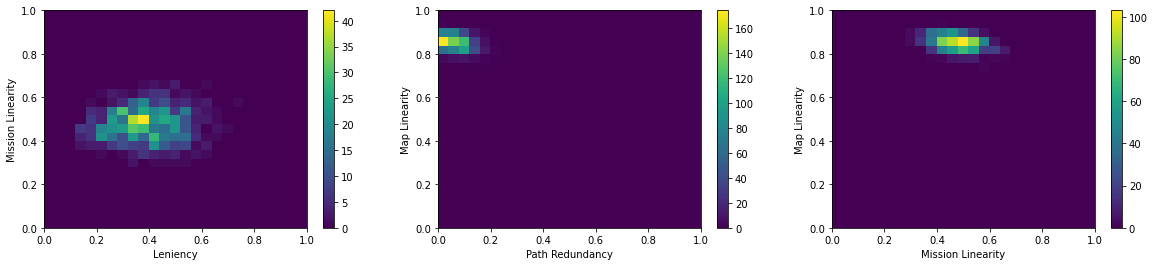

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
# fig = drawExpRange(df, 'Leniency', 'Mission Linearity',thres1, thres2,ax1 [False, False])
alt_df = df[0:1000]
h1 = drawExpRange(alt_df, 'Leniency', 'Mission Linearity',thres1, thres2,ax1, [False, False])
plt.colorbar(h1[3],ax=ax1)
h2 = drawExpRange(alt_df, 'Path Redundancy', 'Map Linearity',thres1, thres2,ax2, [False, False])
plt.colorbar(h2[3],ax=ax2)
h3 = drawExpRange(alt_df, 'Mission Linearity', 'Map Linearity',thres1, thres2,ax3, [False, False])
plt.colorbar(h3[3],ax=ax3)
plt.savefig("pre.png")

In [14]:
thres11 = 0.30
thres12 = 0.40
training_samples = alt_df[alt_df["Leniency"] < thres11]["Sample ID"]
# training_samples = alt_df[alt_df["Mission Linearity"] < thres12]["Sample ID"]
# temp = alt_df[alt_df["Leniency"] > thres11]
# training_samples = temp[temp["Mission Linearity"] > thres12]["Sample ID"]
len(training_samples)

221

In [16]:
alt_df

Unnamed: 0                             Sample ID  Leniency  \
0             0  2bb0e212-fde2-4bfa-b76f-f1f237d109da  0.600000   
1             1  5bbd5304-7874-4470-ab1e-ef2e17bbe042  0.333333   
2             2  43179b90-5582-4dc8-be5d-5d40687eee38  0.370370   
3             3  127afa74-d112-41aa-b706-b8192a477cd4  0.500000   
4             4  24413720-97e9-464a-afd4-a965526f4a47  0.352941   
..          ...                                   ...       ...   
995         995  d30b4665-cc36-45e0-adae-5f327c88af10  0.454545   
996         996  e261a996-4616-4f86-be58-f7fd0cfef3c8  0.590909   
997         997  47713e66-bda6-4bcc-8c4d-82e7afe316e0  0.406250   
998         998  0f7a2237-f684-4acc-bf5f-c366d913d537  0.600000   
999         999  d2e6e012-11c4-4d8e-aeb8-ed38113bc085  0.357143   

     Mission Linearity  Map Linearity  Path Redundancy  More Than Four  Has KM  
0             0.650000       0.833333         0.200000           False   False  
1             0.541667       0.868421         0.000000           False   False  
2             0.444444       0.886364         0.000000           False   False  
3             0.500000       0.900000         0.076923            True    True  
4             0.382353       0.865385         0.029412            True    True  
..                 ...            ...              ...             ...     ...  
995           0.545455       0.766667         0.136364           False   False  
996           0.545455       0.852941         0.136364           False   False  
997           0.406250       0.900000         0.000000            True    True  
998           0.560000       0.842105         0.200000            True    True  
999           0.464286       0.909091         0.035714            True    True  

[1000 rows x 8 columns]

In [15]:
SaveTrainingSet(training_samples, "dormans-grammar")

FileNotFoundError: [Errno 2] No such file or directory: '../data/generation-trees/dormans-grammar/26a10486-5717-484a-8321-a6a9d0fd58a1.pkl'

In [ ]:
config = {"max_applications": 30, "sampling_method": "grammar"}
gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
sample, sample_id = gen.applyRules(config)
gen_altered.learnParameters("../data/trees/training-set-dormans/")

In [ ]:
cleanDir("../data/sample-graphs/dormans-grammar-altered")
trained_df1 = genExamples(gen_altered,config)

In [ ]:
thres21 = 0.04
thres22 = 0.82
training_samples = alt_df[alt_df["Path Redundancy"] < thres21]["Sample ID"]
# training_samples = alt_df[alt_df["Map Linearity"] < thres22]["Sample ID"]
# temp = alt_df[alt_df["Path Redundancy"] > thres21]
# training_samples = temp[temp['Map Linearity']> thres22]["Sample ID"]
len(training_samples)

In [ ]:
SaveTrainingSet(training_samples, "dormans-grammar")

In [ ]:
config = {"max_applications": 30, "sampling_method": "grammar"}
gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
sample, sample_id = gen.applyRules(config)
gen_altered.learnParameters("../data/trees/training-set-dormans/")

In [ ]:
cleanDir("../data/sample-graphs/dormans-grammar-altered")
trained_df2 = genExamples(gen_altered,config)

In [ ]:
thres31 = 0.40
thres32 = 0.82
training_samples = alt_df[alt_df["Mission Linearity"] < thres31]["Sample ID"]
# training_samples = alt_df[alt_df["Map Linearity"] < thres32]["Sample ID"]
# temp = alt_df[alt_df["Mission Linearity"] > thres31]
# training_samples = temp[temp["Map Linearity"] > thres32]["Sample ID"]
len(training_samples)

In [ ]:
SaveTrainingSet(training_samples, "dormans-grammar")

In [ ]:
config = {"max_applications": 30, "sampling_method": "grammar"}
gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
sample, sample_id = gen.applyRules(config)
gen_altered.learnParameters("../data/trees/training-set-dormans/")

In [ ]:
cleanDir("../data/sample-graphs/dormans-grammar-altered")
trained_df3 = genExamples(gen_altered,config)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
# fig = drawExpRange(df, 'Leniency', 'Mission Linearity',thres1, thres2,ax1 [False, False])
h1 = drawExpRange(trained_df1, 'Leniency', 'Mission Linearity',thres11, thres12,ax1, [True, False], 'w')
plt.colorbar(h1[3],ax=ax1)
h2 = drawExpRange(trained_df2, 'Path Redundancy', 'Map Linearity',thres21, thres22,ax2, [True, False], 'w')
plt.colorbar(h2[3],ax=ax2)
h3 = drawExpRange(trained_df3, 'Mission Linearity', 'Map Linearity',thres31, thres32,ax3, [True, False], 'w')
plt.colorbar(h3[3],ax=ax3)
plt.savefig("smaller-3.png")

In [ ]:
# df.to_csv("original-grammar-2.csv")

In [ ]:
temp1 = trained_df1[trained_df1["Leniency"] < thres11]["Sample ID"]
len(temp1)

In [ ]:
temp2 = trained_df2[trained_df2["Path Redundancy"] < thres21]["Sample ID"]
len(temp2)

In [ ]:
temp3 = trained_df3[trained_df3["Mission Linearity"] < thres31]["Sample ID"]
len(temp3)